In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scipy
scipy.__version__

'1.4.1'

In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
cd gdrive

/content/gdrive


In [5]:
cd MyDrive

/content/gdrive/MyDrive


In [6]:
cd omscs-dl-final-project

/content/gdrive/MyDrive/omscs-dl-final-project


In [11]:
# import copy
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# import torch
# import torch.nn as nn
# import torchvision
# import torchvision.transforms as transforms
# from team36.diff_evo import differential_evolution
# from team36.mnist.vgg import VGG
# from team36.attacks.fast_gradient_attack_data_set import FastSignGradientAttackDataSet

# DIR = '.'
# DATA_DIR = f'{DIR}/data'

# training_set = torchvision.datasets.MNIST(root=DATA_DIR, train=True, download=True, 
#                                           transform=transforms.ToTensor())

# prev_model = VGG()
# state_dict = torch.load(f"{DIR}/checkpoints/mnist-vgg.pth", map_location=torch.device('cpu'))
# print(prev_model.load_state_dict(state_dict))
# prev_criterion = nn.CrossEntropyLoss()

# attack_training_set = FastSignGradientAttackDataSet(training_set, prev_model, prev_criterion, 
#                                                     epsilon=0.25)


# indices = torch.randperm(len(attack_training_set))[:int(len(attack_training_set) * 0.1)]
# attack_training_set = torch.utils.data.Subset(attack_training_set, indices)

# combined_training_set = torch.utils.data.ConcatDataset([training_set, attack_training_set])

# training_indices, validation_indices = train_test_split(
#     range(len(combined_training_set)),
#     test_size=0.1,
# )
# training_split = torch.utils.data.Subset(combined_training_set, training_indices)
# validation_split = torch.utils.data.Subset(combined_training_set, validation_indices)

# print(f"{len(training_split)} in training set")
# print(f"{len(validation_split)} in validation set")

import copy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [168]:
import os
import sys
import numpy as np

import argparse

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable

def perturb_image(xs, img):
    with torch.no_grad():
      # plt.figure()
      # plt.imshow(img[0][0].cpu().numpy())
      if xs.ndim < 2:
          xs = np.array([xs])
      # batch = len(xs)
      batch = 32
      imgs = img.repeat(batch, 1, 1, 1)
      xs = xs.astype(int)

      count = 0
      for x in xs:
          pixels = np.split(x, len(x)/5)
          
          for pixel in pixels:
              x_pos, y_pos, r, g, b = pixel
              imgs[count, 0, x_pos, y_pos] = (r/255.0-0.4914)/0.2023
              imgs[count, 1, x_pos, y_pos] = (g/255.0-0.4822)/0.1994
              imgs[count, 2, x_pos, y_pos] = (b/255.0-0.4465)/0.2010
          count += 1
      # x, _ = imgs[0]
      display(transforms.functional.to_pil_image(imgs[0][0]))
      return imgs

def predict_classes(xs, img, target_class, net, minimize=True):
    with torch.no_grad():
        imgs_perturbed = perturb_image(xs, img.clone())
    #     input = Variable(imgs_perturbed, volatile=True).cuda()
        predictions = net(imgs_perturbed).softmax(dim = 1).data.cpu().numpy()[:, target_class]

        return predictions if minimize else 1 - predictions

def attack_success(x, img, target_class, net, targeted_attack=False, verbose=False):
    with torch.no_grad():
        attack_image = perturb_image(x, img.clone())
    #     input = Variable(attack_image, volatile=True).cuda()
        confidence = net(attack_image).softmax(dim = 1).data.cpu().numpy()[0]
        predicted_class = np.argmax(confidence)

        if (verbose):
            print("Confidence: %.4f"%confidence[target_class])
        if (targeted_attack and predicted_class == target_class) or (not targeted_attack and predicted_class != target_class):
            return True


def attack(img, label, net, target=None, pixels=1, maxiter=75, popsize=400, verbose=False):
    # img: 1*3*W*H tensor
    # label: a number
    # plt.figure()
    # plt.imshow(img[0][0].cpu().numpy())
    # print(label)
    with torch.no_grad():
        targeted_attack = target is not None
        target_class = target if targeted_attack else label

        bounds = [(0,32), (0,32), (0,255), (0,255), (0,255)] * pixels

        popmul = max(1, popsize/len(bounds))

        predict_fn = lambda xs: predict_classes(
            xs, img, target_class, net, target is None)
        callback_fn = lambda x, convergence: attack_success(
            x, img, target_class, net, targeted_attack, verbose)

        inits = np.zeros([int(popmul)*int(len(bounds)), int(len(bounds))])
        for init in inits:
            for i in range(pixels):
                init[i*5+0] = np.random.random()*32
                init[i*5+1] = np.random.random()*32
                init[i*5+2] = np.random.normal(128,127)
                init[i*5+3] = np.random.normal(128,127)
                init[i*5+4] = np.random.normal(128,127)

        # print('starting differential_evolution')
        attack_result = differential_evolution(predict_fn, bounds, maxiter=maxiter, popsize=popmul,
            recombination=1, atol=-1, callback=callback_fn, polish=False, init=inits)
        # print("finished differential_evolution")
        attack_image = perturb_image(attack_result.x, img)
        # return (attack_image, label)
        # print(attack_image)
#     #     attack_var = Variable(attack_image, volatile=True).CUDA()
        predicted_probs = net(attack_image).softmax(dim = 1).data.cpu().numpy()[0]

        predicted_class = np.argmax(predicted_probs)

        if (not targeted_attack and predicted_class != label) or (targeted_attack and predicted_class == target_class):
            # return 1, attack_result.x.astype(int)
            return 1, attack_image
        # return 0, [None]
        return 0, attack_image


def attack_all(net, loader, pixels=1, targeted=False, maxiter=75, popsize=400, verbose=False):

    correct = 0
    
    success = 0
    imges = []
    # print(len(loader.dataset))
    with torch.no_grad():
        for batch_idx, (input, target) in enumerate(loader):
            # plt.figure()
            # plt.imshow(input[0][0].cpu().numpy())
            display(transforms.functional.to_pil_image(input[0][0]))
            input = input.cuda()
            target = target.cuda()
            prior_probs = net(input).softmax(dim = 1)
            _, indices = torch.max(prior_probs, 1)

            if target[0] != indices.data.cuda()[0]:
                continue

            correct += 1
            target = target.cpu().numpy()

            targets = [None] if not targeted else range(10)

            for target_class in targets:
                if (targeted):
                    if (target_class == target[0]):
                        continue
                # target_class = 1
                flag, x = attack(input, target[0], net, target_class, pixels=pixels, maxiter=maxiter, popsize=popsize, verbose=verbose)

                imges.append(attack_img)
            # plt.imshow(attack_img.cpu().numpy(), cmap='gray')
            # imges[batch_idx] = (x,target)
                # success += flag
                # if (targeted):
                #     success_rate = float(success)/(9*correct)
                # else:
                #     success_rate = float(success)/correct


                # if flag == 1:
                    # print("success rate: %.4f (%d/%d) [(x,y) = (%d,%d) and (R,G,B)=(%d,%d,%d)]"%(
                        # success_rate, success, correct, x[0],x[1],x[2],x[3],x[4]))

            # if correct == args.samples:
            #     break
    # return success_rate
    # return x, target
    return imges


In [10]:

import os
import sys
import numpy as np

import argparse

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
# from models import *
from team36.util import progress_bar
from torch.autograd import Variable
torch.cuda.empty_cache()
print("==> Loading data and model...")

DIR = '.'
DATA_DIR = f'{DIR}/data'
NAME = 'cifar10'
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
training_set = torchvision.datasets.CIFAR10(root=DATA_DIR, train=True, download=True, 
                                            transform=transforms.ToTensor())

training_indices, validation_indices, _, _ = train_test_split(
    range(len(training_set)),
    training_set.targets,
    stratify=training_set.targets,
    test_size=0.1,
)
training_split = torch.utils.data.Subset(training_set, training_indices)
validation_split = torch.utils.data.Subset(training_set, validation_indices)

print(f"{len(training_split)} in training set")
print(f"{len(validation_split)} in validation set")


import team36
from team36.diff_evo import differential_evolution
from team36.mnist.vgg import VGG
from team36.training import train, validate

learning_rate = 1e-3
momentum = 5e-1
weight_decay = 5e-2
batch_size = 32
epochs = 1

sampler = torch.utils.data.RandomSampler(training_split, replacement=True, num_samples=1000)
training_loader = torch.utils.data.DataLoader(training_split, batch_size=batch_size, sampler=sampler)
test_loader = torch.utils.data.DataLoader(validation_split, batch_size=batch_size, shuffle=False, num_workers=2)

model = VGG(image_size=32, in_channels=3)
if torch.cuda.is_available():
    model = model.cuda()
state_dict = torch.load(f"{DIR}/checkpoints/cifar10-vgg.pth", map_location=torch.device('cuda'))
criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model.parameters(), learning_rate,
                            momentum=momentum, weight_decay=weight_decay)


print("==> Starting attck...")
pixels = 1
maxiter = 100 
popsize = 200
verbose = False
targeted = False
# results = attack_all(model, test_loader, pixels=pixels, targeted=targeted, maxiter=maxiter, popsize=popsize, verbose=verbose)
# print("Final success rate: %.4f"%results)

==> Loading data and model...
Files already downloaded and verified
45000 in training set
5000 in validation set
==> Starting attck...


Files already downloaded and verified


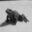

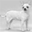

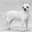

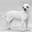

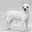

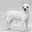

IndexError: ignored

In [ ]:
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms

attack_test_set = torchvision.datasets.CIFAR10(root=DATA_DIR, train=False, download=True, 
                                             transform=transforms.ToTensor())
attack_test_set = attack_all(model, test_loader, pixels=pixels, targeted=targeted, maxiter=maxiter, popsize=popsize, verbose=verbose)

In [ ]:
attack_test_loader = torch.utils.data.DataLoader(attack_test_set, batch_size=157, 
                                                 shuffle=False, num_workers=0)

In [ ]:
attack_test_accuracy, _, attack_test_loss = validate(None, attack_test_loader, model, criterion)

ValueError: ignored

In [7]:
import os
import sys

import copy
import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

DIR = "/content/gdrive/MyDrive/omscs-dl-final-project"
sys.path.append(os.path.abspath(DIR))
DATA_DIR = f'{DIR}/data'

from team36.mnist.vgg import VGG
from team36.diff_evo import differential_evolution
from team36.training import predict

In [186]:
NAME = "cifar10"
DATA_SET_CLASS = torchvision.datasets.CIFAR10
image_size = 32
in_channels = 3
fgsm_alpha = 0.5
fgsm_epsilon = 0.01

model = VGG(image_size=image_size, in_channels=in_channels)
if torch.cuda.is_available():
    model = model.cuda()
state_dict = torch.load(f"{DIR}/checkpoints/{NAME}-vgg.pth")
model.load_state_dict(state_dict)

criterion = nn.CrossEntropyLoss()

In [187]:
class OnePixelAttackDataSet(torch.utils.data.Dataset):
    def __init__(self, baseline_dataset, model, device=None):
        self.baseline_dataset = baseline_dataset
        self.model = model
        self.device = device

    def __getitem__(self, index):
        input, target = self.baseline_dataset[index]

        if self.device is not None:
            input = input.to(self.device)
            
        inputs = input.unsqueeze(0)
        
        flag, adversarial_input = self.attack(input, target, self.model)

        return adversarial_input, target

    def __len__(self):
        return len(self.baseline_dataset)

    def attack(self, img, label, net, target=None, pixels=1, maxiter=75, popsize=400, verbose=False):
      image_size = 32

      # img: 1*3*W*H tensor
      # label: a number
      # plt.figure()
      # plt.imshow(img[0][0].cpu().numpy())
      # print(label)
      with torch.no_grad():
          targeted_attack = target is not None
          target_class = target if targeted_attack else label

          bounds = [(0,image_size), (0,image_size), (0,255), (0,255), (0,255)] * pixels

          popmul = max(1, popsize/len(bounds))

          predict_fn = lambda xs: self.predict_classes(xs, img, target_class, net, target is None)
          callback_fn = lambda x, convergence: self.attack_success(
              x, img, target_class, net, targeted_attack, verbose)

          inits = np.zeros([int(popmul)*int(len(bounds)), int(len(bounds))])
          for init in inits:
              for i in range(pixels):
                  init[i*5+0] = np.random.random()*image_size
                  init[i*5+1] = np.random.random()*image_size
                  init[i*5+2] = np.random.normal(128,127)
                  init[i*5+3] = np.random.normal(128,127)
                  init[i*5+4] = np.random.normal(128,127)

          # print('starting differential_evolution')
          attack_result = differential_evolution(predict_fn, bounds, maxiter=maxiter, popsize=popmul,
              recombination=1, atol=-1, callback=callback_fn, polish=False, init=inits)
          # print("finished differential_evolution")
          attack_image = self.perturb_image(attack_result.x, img)
          # return (attack_image, label)
          # print(attack_image)
          # attack_var = Variable(attack_image, volatile=True).CUDA()
          predicted_probs = net(attack_image).softmax(dim = 1).data.cpu().numpy()[0]

          predicted_class = np.argmax(predicted_probs)

          x = (not targeted_attack and predicted_class != label)
          y = (targeted_attack and predicted_class == target_class)
          if x or y:
              # return 1, attack_result.x.astype(int)
              return 1, attack_image
          # return 0, [None]
          return 0, attack_image

    def predict_classes(self, xs, img, target_class, net, minimize=True):
        with torch.no_grad():
          imgs_perturbed = self.perturb_image(xs, img.clone())
      #     input = Variable(imgs_perturbed, volatile=True).cuda()
          predictions = net(imgs_perturbed).softmax(dim = 1).data.cpu().numpy()[:, target_class]

          return predictions if minimize else 1 - predictions

    def attack_success(self, x, img, target_class, net, targeted_attack=False, verbose=False):
      with torch.no_grad():
        attack_image = self.perturb_image(x, img.clone())
    #     input = Variable(attack_image, volatile=True).cuda()
        confidence = net(attack_image).softmax(dim = 1).data.cpu().numpy()[0]
        predicted_class = np.argmax(confidence)

        if (verbose):
          print("Confidence: %.4f"%confidence[target_class])
        cond_a = (targeted_attack and predicted_class == target_class)
        cond_b = (not targeted_attack and predicted_class != target_class)
        if cond_a or cond_b:
          return True

    def perturb_image(self, xs, img):
      with torch.no_grad():
        # plt.figure()
        # plt.imshow(img[0][0].cpu().numpy())
        if xs.ndim < 2:
            xs = np.array([xs])
        batch = len(xs)
        # batch = 32
        imgs = img.repeat(batch, 1, 1, 1)
        xs = xs.astype(int)

        count = 0
        for x in xs:
            pixels = np.split(x, len(x)/5)
            
            for pixel in pixels:
                x_pos, y_pos, r, g, b = pixel
                # print("x_pos, y_pos, r, g, b", x_pos, y_pos, r, g, b)
                imgs[count, 0, x_pos, y_pos] = (r/255.0-0.4914)/0.2023
                imgs[count, 1, x_pos, y_pos] = (g/255.0-0.4822)/0.1994
                imgs[count, 2, x_pos, y_pos] = (b/255.0-0.4465)/0.2010
            count += 1
        # x, _ = imgs[0]
        # display(transforms.functional.to_pil_image(imgs[0][0]))
        return imgs

test_set = DATA_SET_CLASS(root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())
attack_test_set = OnePixelAttackDataSet(test_set, model, device='cuda')

Files already downloaded and verified


input torch.Size([3, 32, 32])
adversarial_input torch.Size([3, 32, 32])
Ground truth is 3
Test Image prediction is 3


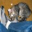

Adversarial Test Image prediction is 5


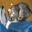

In [188]:
index = 0

input, ground_truth = test_set[index]

adversarial_input, _ = attack_test_set[index]
adversarial_input = adversarial_input[0]

print("input", input.shape)
print("adversarial_input", adversarial_input.shape)

print("Ground truth is", ground_truth)

print("Test Image prediction is", predict(model, input.cuda()))
display(transforms.functional.to_pil_image(input))

print("Adversarial Test Image prediction is", predict(model, adversarial_input.cuda()))
display(transforms.functional.to_pil_image(adversarial_input))

In [189]:
count = 0
attack_count = 0
total = 100
for i in range(total):
  input, ground_truth = test_set[index]
  adversarial_input, _ = attack_test_set[index]
  adversarial_input = adversarial_input[0]

  prediction = predict(model, input.cuda())
  attack_prediction = predict(model, adversarial_input.cuda())

  if prediction == ground_truth:
    count += 1

  if attack_prediction == ground_truth:
    attack_count += 1

print("test accuracy", count / total)
print("attack test accuracy", attack_count / total)

test accuracy 1.0
attack test accuracy 0.02


In [8]:
import matplotlib.pyplot as plt
from IPython.display import Image 
import os
import sys
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

DIR = "/content/gdrive/MyDrive/omscs-dl-final-project"
DATA_DIR = f'{DIR}/data'
NAME = 'cifar10'
DATA_SET_CLASS = torchvision.datasets.CIFAR10
image_size = 32
in_channels = 3
fgsm_alpha = 0.5
fgsm_epsilon = 0.01

sys.path.append(os.path.abspath(DIR))

import team36
from team36.mnist.vgg import VGG
from team36.attacks.fast_gradient_attack_data_set import FastSignGradientAttackDataSet
from team36.defenses.fast_gradient_sign_method_loss import FastGradientSignMethodLoss
from team36.training import validate, accuracy, predict

In [12]:
fmodel = VGG(image_size=image_size, in_channels=in_channels)
if torch.cuda.is_available():
    model = model.cuda()
state_dict = torch.load(f"{DIR}/checkpoints/{NAME}-vgg.pth")
model.load_state_dict(state_dict)

defense_model = VGG(image_size=image_size, in_channels=in_channels)
if torch.cuda.is_available():
    defense_model = defense_model.cuda()
state_dict = torch.load(f"{DIR}/checkpoints/{NAME}-vgg-training-with-fgsm-examples-defense-{fgsm_epsilon}.pth")
defense_model.load_state_dict(state_dict)

criterion = nn.CrossEntropyLoss()

fgsm_reg_defense_model = VGG(image_size=image_size, in_channels=in_channels)
if torch.cuda.is_available():
    fgsm_reg_defense_model = fgsm_reg_defense_model.cuda()
state_dict = torch.load(f"{DIR}/checkpoints/{NAME}-vgg-training-with-fgsm-regularization-defense-{fgsm_epsilon}.pth")
fgsm_reg_defense_model.load_state_dict(state_dict)

cpu_model = VGG(image_size=image_size, in_channels=in_channels)
state_dict = torch.load(f"{DIR}/checkpoints/{NAME}-vgg.pth")
cpu_model.load_state_dict(state_dict)
fgsm_reg_defense_criterion = FastGradientSignMethodLoss(cpu_model, nn.CrossEntropyLoss(), 
                                                        alpha=fgsm_alpha, epsilon=fgsm_epsilon)

In [14]:
 torch.cuda.empty_cache()
test_set = DATA_SET_CLASS(root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())

test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)

test_accuracy, _, test_loss = validate(None, test_loader, model, criterion)
defense_test_accuracy, _, defense_test_loss = validate(None, test_loader, defense_model, criterion)
fgsm_reg_defense_test_accuracy, _, fgsm_reg_defense_test_loss = validate(None, test_loader,
                                                                         fgsm_reg_defense_model, 
                                                                         fgsm_reg_defense_criterion,
                                                                         no_grad=False)

print("No Attack")
print(f"Test Accuracy is {test_accuracy}")
print(f"Test Loss is {test_loss}")

print(f"FGSM Examples Defense Test Accuracy is {defense_test_accuracy}")
print(f"FGSM Examples Defense Test Loss is {defense_test_loss}")

print(f"FGSM Regularization Defense Test Accuracy is {fgsm_reg_defense_test_accuracy}")
print(f"FGSM Regularization Defense Test Loss is {fgsm_reg_defense_test_loss}")

Files already downloaded and verified


RuntimeError: ignored

In [ ]:
test_set = DATA_SET_CLASS(root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())
attack_test_set = OnePixelAttackDataSet(test_set, model, criterion, epsilon=fgsm_epsilon, device='cuda')
attack_test_loader = torch.utils.data.DataLoader(attack_test_set, batch_size=100, shuffle=False)

attack_test_accuracy, _, attack_test_loss = validate(None, attack_test_loader, model, criterion)
attack_defense_test_accuracy, _, attack_defense_test_loss = validate(None, attack_test_loader, 
                                                                     defense_model, criterion)
attack_fgsm_reg_defense_test_accuracy, _, attack_fgsm_reg_defense_test_loss = validate(
    None, attack_test_loader, fgsm_reg_defense_model, fgsm_reg_defense_criterion, no_grad=False)


print("Attack")
print(f"Test Accuracy is {attack_test_accuracy}")
print(f"Test Loss is {attack_test_loss}")

print(f"FGSM Examples Defense Test Accuracy is {attack_defense_test_accuracy}")
print(f"FGSM Examples Defense Test Loss is {attack_defense_test_loss}")

print(f"FGSM Regularization Defense Test Accuracy is {attack_fgsm_reg_defense_test_accuracy}")
print(f"FGSM Regularization Defense Test Loss is {attack_fgsm_reg_defense_test_loss}")

In [ ]:
index = 1 # mnist
# index = 0 # cifar10

input, ground_truth = test_set[index]
input = input.cuda()

print("ground truth", ground_truth)

print("no attack", predict(model, input))
display(transforms.functional.to_pil_image(input))
print()

adversarial_input, _ = attack_test_set[index]
adversarial_input = adversarial_input.cuda()

print("attack, no defense", predict(model, adversarial_input))
display(transforms.functional.to_pil_image(adversarial_input))
print()

print("attack, FGSM training defense", predict(defense_model, adversarial_input))
display(transforms.functional.to_pil_image(adversarial_input))
print()

print("attack, FGSM loss defense", predict(fgsm_reg_defense_model, adversarial_input))
display(transforms.functional.to_pil_image(adversarial_input))
print()

image_dir = f"{DIR}/images"

pil_image = transforms.functional.to_pil_image(input)
pil_image.save(f"{image_dir}/{NAME}-{str(index)}.png")

pil_image = transforms.functional.to_pil_image(adversarial_input)
pil_image.save(f"{image_dir}/{NAME}-{str(index)}-{fgsm_epsilon}-fgsm-adversarial.png")